In [ ]:
pip install FiftyOne

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip

--2022-12-20 13:24:59--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.82.244, 52.216.101.163, 52.217.102.68, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.82.244|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  10.6MB/s    in 13m 9s  

2022-12-20 13:38:08 (16.3 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip

--2022-12-20 13:56:51--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.9.147, 52.216.36.169, 52.217.159.33, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.9.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  32.0MB/s    in 8.1s    

2022-12-20 13:56:59 (29.8 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]



In [ ]:
!unzip annotations_trainval2014.zip > /dev/null

In [ ]:
!unzip train2014.zip > /dev/null

In [ ]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train2014", {}, "./annotations/instances_train2014.json", "./train2014")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

In [ ]:
from detectron2.data import MetadataCatalog, DatasetCatalog
metadata = MetadataCatalog.get("train2014")
dataset_dicts = DatasetCatalog.get("train2014")

Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



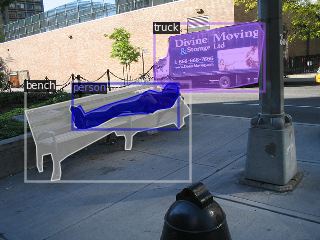

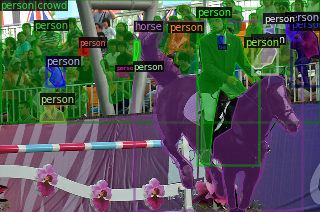

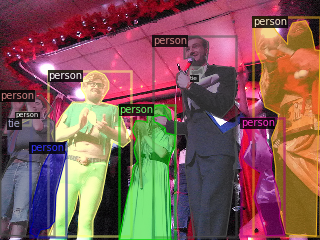

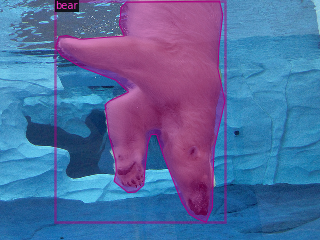

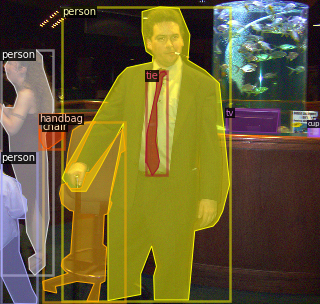

In [ ]:
import random
import cv2
from google.colab.patches import cv2_imshow
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train2014",)
cfg.DATASETS.TEST = ()  # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02
cfg.SOLVER.MAX_ITER = (100)  # 100 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (128)  # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 3 classes (data, fig, hazelnut)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

#
# Only the required images will be downloaded (if necessary).
# By default, only detections are loaded
#

dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["validation","train"],
    #classes=["car"],
    label_types=["segmentations"],
    max_samples=50,
)

# Visualize the dataset in the FiftyOne App
session = fo.launch_app(dataset)

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


Sufficient images already downloaded


INFO:fiftyone.utils.coco:Sufficient images already downloaded


Existing download of split 'train' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'train' is sufficient


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████████| 50/50 [1.2s elapsed, 0s remaining, 42.7 samples/s]         


INFO:eta.core.utils: 100% |███████████████████| 50/50 [1.2s elapsed, 0s remaining, 42.7 samples/s]         


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


 100% |███████████████████| 50/50 [1.1s elapsed, 0s remaining, 45.4 samples/s]         


INFO:eta.core.utils: 100% |███████████████████| 50/50 [1.1s elapsed, 0s remaining, 45.4 samples/s]         


Dataset 'coco-2017-validation-train-50' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation-train-50' created


# **Detectron Installation**

In [ ]:
# Properly install detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


In [ ]:
from fiftyone import ViewField as F

# Remove other classes and existing tags
#dataset.filter_labels("segmentations", F("label") == "Vehicle registration plate").save()
dataset.untag_samples("validation")

import fiftyone.utils.random as four
four.random_split(dataset, {"train": 0.8, "val": 0.2})

In [ ]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
from detectron2.structures import BoxMode

def get_fiftyone_dicts(samples):
    samples.compute_metadata()

    dataset_dicts = []
    for sample in samples.select_fields(["id", "filepath", "metadata", "segmentations"]):
        height = sample.metadata["height"]
        width = sample.metadata["width"]
        record = {}
        record["file_name"] = sample.filepath
        record["image_id"] = sample.id
        record["height"] = height
        record["width"] = width

        objs = []
        for det in sample.segmentations.detections:
            tlx, tly, w, h = det.bounding_box
            bbox = [int(tlx*width), int(tly*height), int(w*width), int(h*height)]
            fo_poly = det.to_polyline()
            poly = [(x*width, y*height) for x, y in fo_poly.points[0]]
            poly = [p for x in poly for p in x]
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)

        record["annotations"] = objs
        dataset_dicts.append(record)

    return dataset_dicts

for d in ["train", "val"]:
    view = dataset.match_tags(d)
    DatasetCatalog.register("fiftyone_" + d, lambda view=view: get_fiftyone_dicts(view))
    #MetadataCatalog.get("fiftyone_" + d).set(thing_classes=["vehicle_registration_plate"])

metadata = MetadataCatalog.get("fiftyone_train")

In [ ]:
dataset_dicts = get_fiftyone_dicts(dataset.match_tags("train"))
ids = [dd["image_id"] for dd in dataset_dicts]

view = dataset.select(ids)
session = fo.launch_app(view)

In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fiftyone_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (Vehicle registration plate). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
detectron2.data.DatasetCatalog(dict)


In [ ]:
import os
from detectron2.data.datasets import register_coco_instances
register_coco_instances("coco-2017", {}, dataset.get_annotation_info, dataset.get_annotation_info)
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.DATASETS.TRAIN = "coco-2017"
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
!wget https://github.com/Tony607/detectron2_instance_segmentation_demo/releases/download/V0.1/data.zip
!unzip data.zip > /dev/null